In [1]:
# https://support.google.com/trends/answer/12764470?hl=en#:~:text=You%20can%20access%20anonymized%2C%20indexed,from%20the%20past%2030%20days.

In [115]:
"""Download Google Trends data (finicky so separate from download_data.py for now)"""

import glob
import logging
import os
import time
from datetime import datetime

import pandas as pd
from pandas.tseries.offsets import MonthBegin, MonthEnd
import plotly.express as px
from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError
import requests
import re

# Load data
gt_monthly_files = glob.glob('gt_monthly_*.csv')
gt_monthly_latest = max(gt_monthly_files, key=os.path.getctime)
gt_monthly_raw = pd.read_csv(gt_monthly_latest, parse_dates=['start_date','end_date'])

gt_weekly_files = glob.glob('gt_weekly_*.csv')
gt_weekly_latest = max(gt_weekly_files, key=os.path.getctime)
gt_weekly_raw = pd.read_csv(gt_weekly_latest, parse_dates=['start_date','end_date'])

gt_daily_files = glob.glob('gt_daily_*.csv')
gt_daily_latest = max(gt_daily_files, key=os.path.getctime)
gt_daily_raw = pd.read_csv(gt_daily_latest, parse_dates=['date'])

params_return_empty_df_files = glob.glob('params_return_empty_df_*.txt')
params_return_empty_df_files_latest = max(params_return_empty_df_files, key=os.path.getctime)
with open(params_return_empty_df_files_latest, "r", encoding="utf-8") as f:
    params_return_empty_df_raw = [line.strip() for line in f]

# Config
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',force=True)

pytrends = TrendReq(retries=8, backoff_factor=2)

past_weekly_requests = set(gt_weekly_raw['pytrends_params'])
# params_return_empty_df_raw only in daily for now
past_daily_requests = set(list(gt_daily_raw['pytrends_params'])+params_return_empty_df_raw) 

new_keyword = None

if new_keyword:
    my_kws = set(list(gt_daily_raw['search_term'].unique())+[new_keyword])
else:
    my_kws = set(gt_daily_raw['search_term'])

In [3]:
# Build year ranges to pull weekly data (Google Trends returns weekly data when a full year
# is requested). Check if we already have the data for the keyword and year, don't need to
# make the request again.
years = list(range(2004, datetime.now().year+1))
year_ranges = [(f'{year}-01-01 {year}-12-31') for year in years]

logging.info('Since 2004 there are %d year ranges', len(year_ranges))
kw_yrc = {}
kw_yrtd = {}
for kw in my_kws:
    kw_data = gt_weekly_raw.loc[gt_weekly_raw['search_term']==kw]

    year_ranges_completed = kw_data['pytrends_params'].str.extract(r'"(\d{4}-\d{2}-\d{2} \d{4}-\d{2}-\d{2})"')[0]
    year_ranges_completed = list(set(year_ranges_completed))

    kw_yrc[kw] = year_ranges_completed
    logging.info('Already have %d year ranges for "%s"', len(kw_yrc[kw]), kw)

    year_ranges_to_do = [x for x in year_ranges if x not in kw_yrc[kw]]
    year_ranges_to_do.sort()

    kw_yrtd[kw] = year_ranges_to_do
    logging.info('Need to get %d year ranges for "%s"', len(year_ranges_to_do), kw)

# Build week ranges to pull daily data (Google Trends returns daily data when one week is
# requested) Check if we already have the data for the keyword and week, don't need to make
# the request again.
week_ranges = list(gt_weekly_raw['start_date'].astype(str)+" "+gt_weekly_raw['end_date'].astype(str))
week_ranges = list(set(week_ranges))

params_return_empty_df_dict ={}
for kw in my_kws:
    extracted_dates = [re.search(r'"(\d{4}-\d{2}-\d{2} \d{4}-\d{2}-\d{2})"', s) for s in params_return_empty_df_raw if kw in s]
    params_return_empty_df_dict[kw] = [match.group(1) for match in extracted_dates]

logging.info('Since 2004 there are %d week ranges', len(week_ranges))
kw_wrc = {}
kw_wrtd = {}
for kw in my_kws:
    kw_data = gt_daily_raw.loc[gt_daily_raw['search_term']==kw]

    week_ranges_completed = kw_data['pytrends_params'].str.extract(r'"(\d{4}-\d{2}-\d{2} \d{4}-\d{2}-\d{2})"')[0]
    week_ranges_completed = list(set(week_ranges_completed))

    kw_wrc[kw] = week_ranges_completed
    logging.info('Already have %d week ranges for "%s"', len(kw_wrc[kw]), kw)

    week_ranges_to_do = [x for x in week_ranges if x not in kw_wrc[kw]]
    week_ranges_to_do.sort()

    kw_wrtd[kw] = week_ranges_to_do
    logging.info('Need to get %d week ranges for "%s"', len(week_ranges_to_do), kw)

    if params_return_empty_df_dict[kw]:
        logging.info(
            'But %d params returned empty data frames, so just need %d week ranges for "%s"',
            len(params_return_empty_df_dict[kw]),
            len(week_ranges_to_do)-len(params_return_empty_df_dict[kw]),
            kw
        )

2025-03-22 19:13:04,576 - INFO - Since 2004 there are 22 year ranges
2025-03-22 19:13:04,583 - INFO - Already have 22 year ranges for "AAPL"
2025-03-22 19:13:04,583 - INFO - Need to get 0 year ranges for "AAPL"
2025-03-22 19:13:04,586 - INFO - Already have 22 year ranges for "inflation"
2025-03-22 19:13:04,587 - INFO - Need to get 0 year ranges for "inflation"
2025-03-22 19:13:04,592 - INFO - Since 2004 there are 1108 week ranges
2025-03-22 19:13:04,604 - INFO - Already have 1085 week ranges for "AAPL"
2025-03-22 19:13:04,611 - INFO - Need to get 23 week ranges for "AAPL"
2025-03-22 19:13:04,612 - INFO - But 23 params returned empty data frames, so just need 0 week ranges for "AAPL"
2025-03-22 19:13:04,620 - INFO - Already have 1108 week ranges for "inflation"
2025-03-22 19:13:04,626 - INFO - Need to get 0 week ranges for "inflation"


In [4]:
# Get the interest index by month since 2004
dat = []
for kw in my_kws:
    try:
        pytrends.build_payload([kw], cat=0, timeframe=f'2004-01-01 {datetime.now().strftime("%Y-%m-%d")}', geo="US")
        df = pytrends.interest_over_time()
        df = df.reset_index()
        df = df.rename(columns={'date':'start_date', kw:'index'})
        df['end_date'] = df['start_date'] + MonthEnd(0)
        df['search_term'] = kw
        df['pytrends_params'] = str(pytrends.token_payload)

        dat.append(df)

    except requests.exceptions.RequestException as e:
        logging.error("RequestException: %s", e)

    except ResponseError as e:
        logging.error("ResponseError: %s", e)

if dat:
    gt_monthly_new = pd.concat(dat)

    gt_monthly = pd.concat([gt_monthly_raw,gt_monthly_new])
    gt_monthly = gt_monthly.drop_duplicates()

    gt_monthly.to_csv(f'gt_monthly_{datetime.today().strftime("%Y%m%d")}.csv', index=False)

/opt/anaconda3/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/opt/anaconda3/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


In [5]:
# Get the interest index by week for each year for the selected keywords
for kw in my_kws:
    try:
        dat = []
        for one_year_timeframe in kw_yrtd[kw]:
            pytrends.build_payload([kw], cat=0, timeframe=one_year_timeframe, geo="US")

            if str(pytrends.token_payload) not in past_weekly_requests:
                weekly_us = pytrends.interest_over_time()
                weekly_us = weekly_us.reset_index()
                weekly_us = weekly_us.rename(columns={'date':'start_date', kw:'index'})
                weekly_us['end_date'] = weekly_us['start_date'] + pd.Timedelta(days=6)
                weekly_us['search_term'] = kw
                weekly_us['pytrends_params'] = str(pytrends.token_payload)

                dat.append(weekly_us)
            time.sleep(1)

    finally:
        if dat:
            gt_weekly_new = pd.concat(dat)

            gt_weekly = pd.concat([gt_weekly_raw,gt_weekly_new])
            gt_weekly = gt_weekly.drop_duplicates()

            gt_weekly.to_csv(f'gt_weekly_{datetime.today().strftime("%Y%m%d")}.csv', index=False)
        time.sleep(1)

In [6]:
# Get the interest index by day for each week for the selected keyword
params_return_empty_df_new = []
for kw in my_kws:
    try:
        dat = []
        for one_week_timeframe in kw_wrtd[kw]:
            if one_week_timeframe in params_return_empty_df_dict[kw]:
                continue
            pytrends.build_payload([kw], cat=0, timeframe=one_week_timeframe, geo="US")
            logging.info('%s "%s" Payload built successfully', one_week_timeframe, kw)

            if str(pytrends.token_payload) not in past_daily_requests:
                logging.info("This week is new, gathering interest_over_time...")

                for _attempt in range(3):
                    try:
                        daily_us = pytrends.interest_over_time()
                        daily_us = daily_us.reset_index()
                        daily_us = daily_us.rename(columns={kw:'index'})
                        daily_us['search_term'] = kw
                        daily_us['pytrends_params'] = str(pytrends.token_payload)
                        dat.append(daily_us)
                        logging.info("Success!")
                        if len(daily_us)==0:
                            params_return_empty_df_new.append(str(pytrends.token_payload))
                        break
                    except requests.exceptions.RequestException as e:
                        logging.error('RequestException: %s',e)
                        if _attempt<2:
                            logging.error('Sleeping for 71s and then trying attempt %d...',_attempt+2)
                            time.sleep(71)
                    except ResponseError as e:
                        logging.error("ResponseError: %s", e)
                        if _attempt<2:
                            logging.error('Sleeping for 71s and then trying attempt %d...',_attempt+2)
                            time.sleep(71)

            time.sleep(2)

    finally:
        print(f"hit finally block here on kw={kw}")
        if dat:
            gt_daily_new = pd.concat(dat)

            gt_daily = pd.concat([gt_daily_raw,gt_daily_new])
            gt_daily = gt_daily.drop_duplicates()

            gt_daily.to_csv(f'gt_daily_{datetime.today().strftime("%Y%m%d")}.csv', index=False)

        if params_return_empty_df_new:
            params_return_empty_df = params_return_empty_df_raw+params_return_empty_df_new
            with open(f"params_return_empty_df_{datetime.today().strftime("%Y%m%d")}.txt", "w", encoding="utf-8") as f:
                f.writelines(f"{item}\n" for item in params_return_empty_df)

hit finally block here on kw=AAPL
hit finally block here on kw=inflation


In [231]:
# Clean up (just uses raw files)
index_of_month = gt_monthly_raw.copy()
index_of_month['params_date_range'] = index_of_month['pytrends_params'].str.extract(r'"(\d{4}-\d{2}-\d{2} \d{4}-\d{2}-\d{2})"')[0]
index_of_month = index_of_month.loc[index_of_month['params_date_range']==max(index_of_month['params_date_range'])]
index_of_month = index_of_month.rename(columns={'start_date':'month_start','index':'index_of_month'})
index_of_month['month_end'] = index_of_month['month_start'] + MonthEnd(0)
index_of_month = index_of_month[['month_start','index_of_month','search_term']]
index_of_month = index_of_month.drop_duplicates(subset=['month_start', 'search_term'], keep='first')

# there are duplicate start_date/search_term rows because weeks can be spread across different years
# smart way to adjust this would be weighted average based on days of week in each year
# just keeping the first row for now, come back to this later
index_of_week = gt_weekly_raw.drop_duplicates(subset=['start_date', 'search_term'], keep='first')
index_of_week = index_of_week[['start_date','index','search_term']]
index_of_week = index_of_week.rename(columns={'start_date':'week_start_sun','index':'index_of_week'})

index_of_day = gt_daily_raw.copy()
index_of_day['day_of_week'] = index_of_day['date'].dt.day_name()
index_of_day['week_start_sun'] = index_of_day["date"].dt.to_period("W-SAT").dt.start_time
index_of_day['month_start'] = index_of_day["date"] - MonthBegin(1)

gt_adjusted = index_of_day.merge(index_of_week, how='left', on=['week_start_sun','search_term'])
gt_adjusted = gt_adjusted.merge(index_of_month, how='left', on=['month_start','search_term'])

gt_adjusted['index'] = gt_adjusted['index']*gt_adjusted['index_of_week']/100
gt_adjusted['index'] = gt_adjusted['index']*gt_adjusted['index_of_month']/100
gt_adjusted = gt_adjusted[['date','day_of_week','search_term','index']]

gt_adjusted.to_csv(f'gt_adjusted_{datetime.today().strftime("%Y%m%d")}.csv', index=False)

In [239]:
gt_adjusted

,date,day_of_week,search_term,index
0,2023-12-31,Sunday,inflation,18.2000
1,2024-01-01,Monday,inflation,16.9000
2,2024-01-02,Tuesday,inflation,20.1600
3,2024-01-03,Wednesday,inflation,24.0000
4,2024-01-04,Thursday,inflation,22.5600
...,...,...,...,...
15338,2025-03-18,Tuesday,AAPL,9.8136
15339,2025-03-19,Wednesday,AAPL,10.0392
15340,2025-03-20,Thursday,AAPL,9.1368
15341,2025-03-21,Friday,AAPL,8.6856


In [241]:
gt_adjusted_pivot = gt_adjusted.pivot(
    index='date', columns='search_term',
    values=['index']
)

gt_adjusted_pivot.columns = ['_'.join(col).strip() for col in gt_adjusted_pivot.columns.values]
gt_adjusted_pivot = gt_adjusted_pivot.reset_index().rename_axis(None, axis=1)
gt_adjusted_pivot

,date,index_AAPL,index_inflation
0,2004-01-01,NaN,NaN
1,2004-01-02,NaN,12.2500
2,2004-01-03,NaN,9.8000
3,2004-01-04,NaN,0.0000
4,2004-01-05,NaN,0.0000
...,...,...,...
7747,2025-03-18,9.8136,36.0824
7748,2025-03-19,10.0392,NaN
7749,2025-03-20,9.1368,NaN
7750,2025-03-21,8.6856,NaN


In [8]:
# Checking
# gt_monthly_new   # just swith to use monthly new! always want the lastest anyway
# gt_monthly_raw.loc[gt_monthly_raw['start_date']=="2004-03-01"]
# xx = gt_monthly_raw.loc[gt_monthly_raw['search_term']=="AAPL"].sort_values(by='start_date')
# xx['pytrends_params'][255]

# gt_weekly_raw.loc[gt_weekly_raw['search_term']=="AAPL"]
# gt_weekly_raw.sort_values(by='start_date')
# gt_weekly_raw.loc[gt_weekly_raw['start_date']=="2004-04-07"]

# gt_daily_raw.sort_values(by='date')
# gt_daily_raw.loc[gt_daily_raw['date']=="2004-03-26"]
# gt_daily_raw.loc[gt_daily_raw['search_term']=="AAPL"].sort_values(by='date')

# index_of_week.loc[index_of_week['week_start_sun']=="2004-03-21"]
# index_of_day.loc[index_of_day['date']=="2004-03-26"]

# gt_adjusted.loc[gt_adjusted['date']=="2004-03-26"]

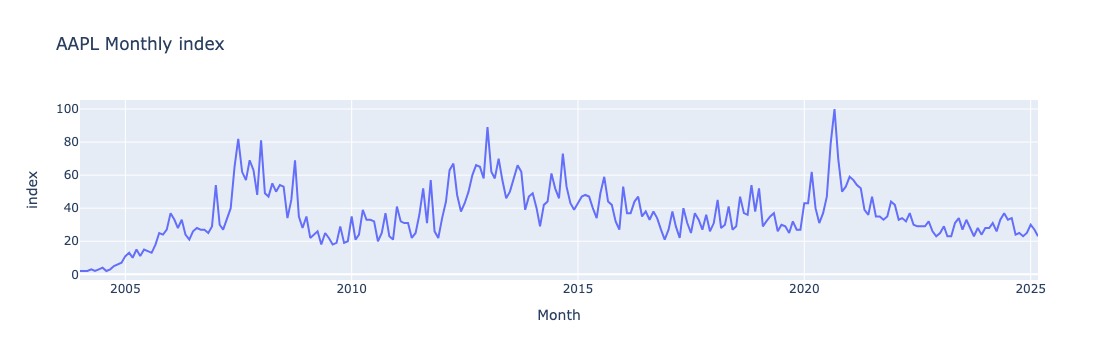

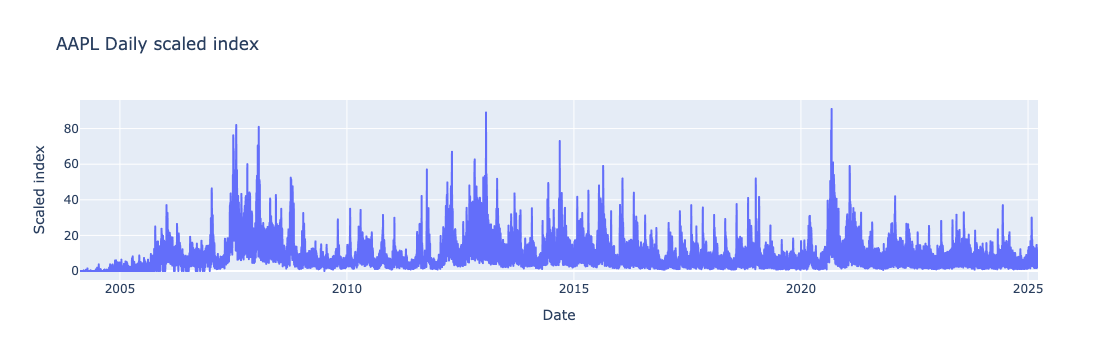

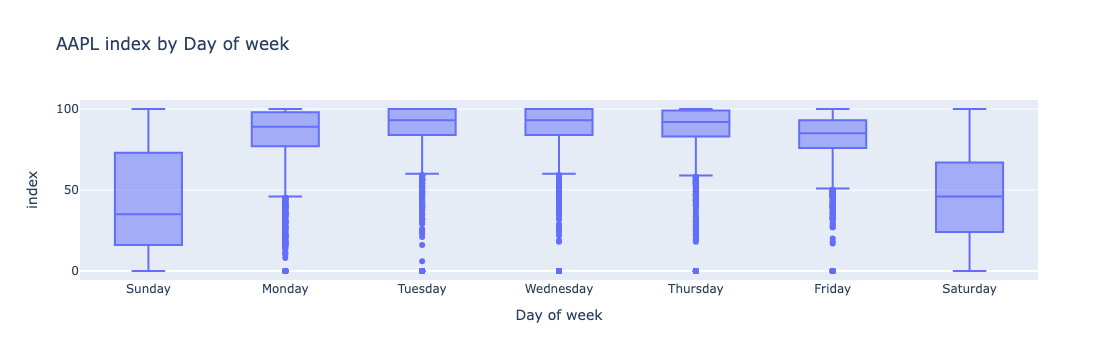

In [67]:
selected_kw = "AAPL"

for_monthly = gt_monthly_new.loc[gt_monthly_new['search_term']==selected_kw].sort_values(by='start_date')
for_daily = gt_adjusted.loc[gt_adjusted['search_term']==selected_kw].sort_values(by='date')

fig1 = px.line(for_monthly, x="start_date", y="index", labels={'start_date':'Month'},title=f'{selected_kw} Monthly index')
fig2 = px.line(for_daily, x="date", y="index",labels={'date':'Date','index':'Scaled index'},title=f'{selected_kw} Daily scaled index')
fig3 = px.box(index_of_day, x="day_of_week", y="index",labels={'day_of_week':'Day of week'},title=f'{selected_kw} index by Day of week')
fig3.update_xaxes(categoryorder='array', categoryarray=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
fig1.show()
fig2.show()
fig3.show()